# Checking results from Magphys SED fitting on sources from LH field

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time, localtime, strftime
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.io import fits
from astropy.visualization import ZScaleInterval

In [2]:
### For Lockman Hole ###
field = 'LockmanHole'
catalogue_file = 'lockman_match_final.csv'
magphys_file = 'lockman_magphys.csv'
map_lofar_file = 'lockman_radio_image.fits'
rms_lofar_file = 'lockman_radio_rms_image.fits'

In [3]:
#path = "/home/bruno/Documents/ESO/Data/"+field+"/"
path = "C:\\Users\\bruno\\Documents\\Documents\\ESO\\Data\\"+field+"\\"

## Opening file and reading data onto a dataframe

### The following table includes galaxies already selected as having good quality data, and cross-matched with the radio catalog from LoTSS Deep Fields DR1

In [4]:
# Selecting columns to read:
columns = ['ID_1','RA_1','DEC_1','Z_BEST_1','z','Mass_median_2','K_flux','AGN_1','ch1_swire_flux','ch2_swire_flux','ch3_swire_flux','ch4_swire_flux','NUV_rest','r_rest_2','J_rest_2','Peak_flux','Total_flux','S_Code']
start_time1 = time()
# Reading the data:
table = pd.read_csv(path+'Catalogues/'+catalogue_file,usecols=columns)
end_time1 = time()
print(f"Creating dataframe took {end_time1-start_time1:.4g} seconds!")
table['S_Code'] = table['S_Code'].astype("category")
table.info()
print(f"Number of galaxies in catalogue: {len(table)}")

Creating dataframe took 9.006 seconds!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 965055 entries, 0 to 965054
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   ID_1            965055 non-null  int64   
 1   RA_1            965055 non-null  float64 
 2   DEC_1           965055 non-null  float64 
 3   K_flux          965055 non-null  float64 
 4   ch1_swire_flux  965055 non-null  float64 
 5   ch2_swire_flux  965055 non-null  float64 
 6   ch3_swire_flux  965055 non-null  float64 
 7   ch4_swire_flux  965055 non-null  float64 
 8   Z_BEST_1        965055 non-null  float64 
 9   AGN_1           965055 non-null  int64   
 10  z               965055 non-null  float64 
 11  Mass_median_2   954536 non-null  float64 
 12  r_rest_2        963257 non-null  float64 
 13  J_rest_2        963257 non-null  float64 
 14  NUV_rest        963257 non-null  float64 
 15  Total_flux      17637 non-null   float64 
 16 

In [5]:
table.index = list(table['ID_1'])

## Getting rid of luminous AGN
We will discard entries of the catalog wich are likely to be luminous AGN and could thus be contaminating our sample. We will select them based on wether they are marked as AGN, or if they meet the IR AGN criteria presented by Donley et al. (2012).

In [6]:
print(f"Entries flagged as optical, IR or X-ray AGN: {np.count_nonzero(table['AGN_1'])}")
table['x'] = np.log10(table['ch3_swire_flux']/table['ch1_swire_flux'])
table['y'] = np.log10(table['ch4_swire_flux']/table['ch2_swire_flux'])
Donley = '(x>=0.08)&(y>=0.15)&(y>=(1.21*x)-0.27)&(y<=(1.21*x)+0.27)&(ch4_swire_flux>ch3_swire_flux>ch2_swire_flux>ch1_swire_flux)'
print(f"Entries that meet the Donley et al. (2012) IR AGN criteria: {len(table.query(Donley))}")

Entries flagged as optical, IR or X-ray AGN: 1564
Entries that meet the Donley et al. (2012) IR AGN criteria: 6339


C:\Users\bruno\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\bruno\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
print(f"Total entries to be excluded for containing bright AGN: {len(table.query(Donley+'|(AGN_1==1)'))}")

Total entries to be excluded for containing bright AGN: 6850


In [8]:
table = table.query('~('+Donley+')')

In [9]:
table = table[table['AGN_1']==0]
print(f"Number of galaxies in sample: {len(table)}")

Number of galaxies in sample: 958205


## Including results from MagPhys SED fitting

In [10]:
# Selecting columns to read:
columns = ['galaxy_id','Mstar_best','Mstar_50','SFR_best','SFR_50','chi2_99_flag']
start_time1 = time()
# Reading the data:
magphys = pd.read_csv(path+'Catalogues/'+magphys_file,usecols=columns)
end_time1 = time()
print(f"Creating dataframe took {end_time1-start_time1:.4g} seconds!")
magphys.info()
print(f"Number of galaxies in catalogue: {len(magphys)}")

Creating dataframe took 1.533 seconds!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290672 entries, 0 to 290671
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   galaxy_id     290672 non-null  int64  
 1   chi2_99_flag  290672 non-null  int64  
 2   Mstar_best    290672 non-null  float64
 3   Mstar_50      290672 non-null  float64
 4   SFR_best      290672 non-null  float64
 5   SFR_50        290672 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 13.3 MB
Number of galaxies in catalogue: 290672


In [11]:
magphys.index = list(magphys['galaxy_id'])
table = pd.concat([table,magphys],axis=1)

del magphys

In [12]:
table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 982986 entries, 1602799 to 2271814
Data columns (total 26 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   ID_1            958205 non-null  float64 
 1   RA_1            958205 non-null  float64 
 2   DEC_1           958205 non-null  float64 
 3   K_flux          958205 non-null  float64 
 4   ch1_swire_flux  958205 non-null  float64 
 5   ch2_swire_flux  958205 non-null  float64 
 6   ch3_swire_flux  958205 non-null  float64 
 7   ch4_swire_flux  958205 non-null  float64 
 8   Z_BEST_1        958205 non-null  float64 
 9   AGN_1           958205 non-null  float64 
 10  z               958205 non-null  float64 
 11  Mass_median_2   948076 non-null  float64 
 12  r_rest_2        956408 non-null  float64 
 13  J_rest_2        956408 non-null  float64 
 14  NUV_rest        956408 non-null  float64 
 15  Total_flux      17116 non-null   float64 
 16  Peak_flux       17116 non-null 

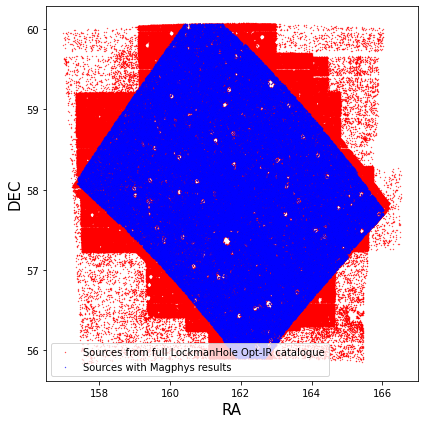

In [13]:
fig,ax = plt.subplots(figsize=(6,6))
ax.set_xlabel('RA',size=15)
ax.set_ylabel('DEC',size=15)
ax.scatter(table['RA_1'],table['DEC_1'],s=0.1,color='r',label='Sources from full '+field+' Opt-IR catalogue')
ax.scatter(table.loc[np.isfinite(table['SFR_50']),'RA_1'],table.loc[np.isfinite(table['SFR_50']),'DEC_1'],s=0.1,color='b',label='Sources with Magphys results')
ax.legend(numpoints=1,loc='best')
fig.tight_layout()
plt.show()

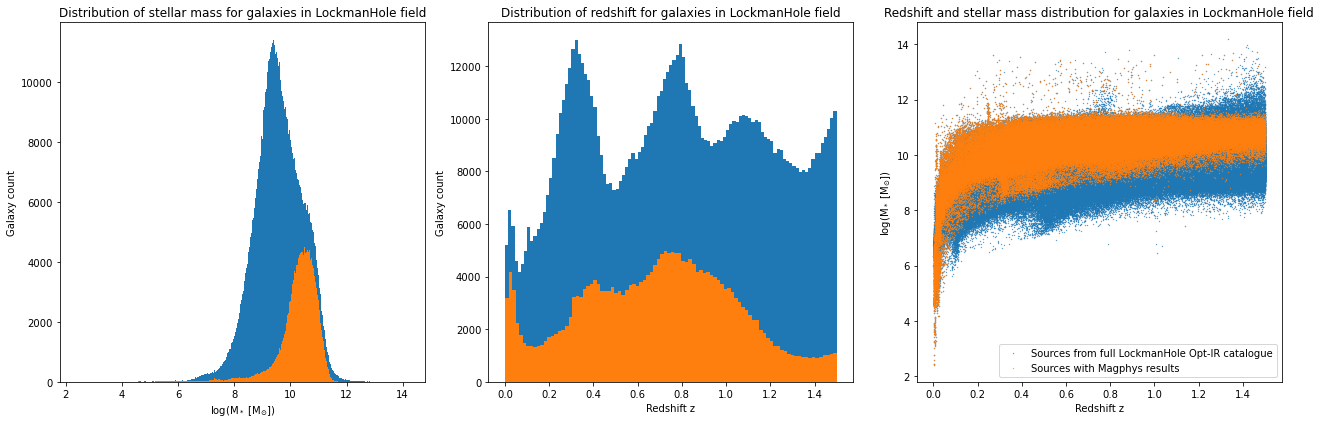

In [14]:
fig, ax = plt.subplots(1,3,figsize=(18,6))
# Plotting stellar mass histogram
ax[0].set_title('Distribution of stellar mass for galaxies in '+field+' field')
ax[0].set_xlabel('log(M$_*$ [M$_{\odot}$])')
ax[0].set_ylabel('Galaxy count')
ax[0].hist(table['Mass_median_2'], 'auto')
ax[0].hist(table.loc[np.isfinite(table['SFR_50']),'Mass_median_2'], 'auto')
# Plotting redshift histogram
ax[1].set_title('Distribution of redshift for galaxies in '+field+' field')
ax[1].set_xlabel('Redshift z')
ax[1].set_ylabel('Galaxy count')
ax[1].hist(table['z'], 'auto')
ax[1].hist(table.loc[np.isfinite(table['SFR_50']),'z'], 'auto')
# Plotting Stellar mass vs Redshift
ax[2].set_title('Redshift and stellar mass distribution for galaxies in '+field+' field')
ax[2].set_xlabel("Redshift z",fontsize=10)
ax[2].set_ylabel("log(M$_*$ [M$_{\odot}$])",fontsize=10)
ax[2].scatter(table['z'],table['Mass_median_2'],s=0.1,label='Sources from full '+field+' Opt-IR catalogue')
ax[2].scatter(table.loc[np.isfinite(table['SFR_50']),'z'],table.loc[np.isfinite(table['SFR_50']),'Mass_median_2'],s=0.1,label='Sources with Magphys results')
ax[2].legend(numpoints=1, loc='best')
fig.tight_layout()
plt.show()

C:\Users\bruno\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


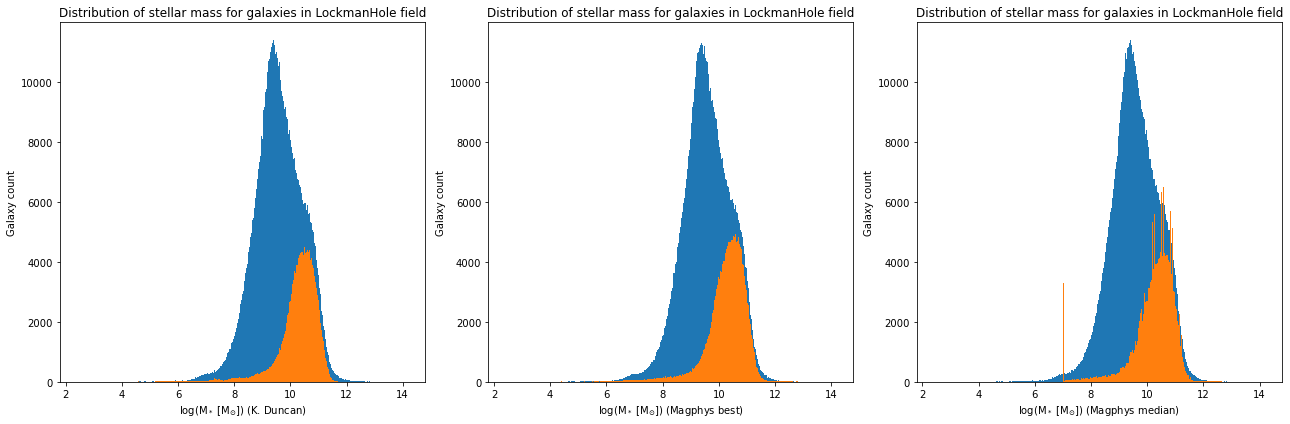

In [15]:
fig, ax = plt.subplots(1,3,figsize=(18,6))
# Plotting stellar mass histogram
ax[0].set_title('Distribution of stellar mass for galaxies in '+field+' field')
ax[0].set_xlabel('log(M$_*$ [M$_{\odot}$]) (K. Duncan)')
ax[0].set_ylabel('Galaxy count')
ax[0].hist(table['Mass_median_2'], 'auto')
ax[0].hist(table.loc[np.isfinite(table['SFR_50']),'Mass_median_2'], 'auto')
# Plotting redshift histogram
ax[1].set_title('Distribution of stellar mass for galaxies in '+field+' field')
ax[1].set_xlabel('log(M$_*$ [M$_{\odot}$]) (Magphys best)')
ax[1].set_ylabel('Galaxy count')
ax[1].hist(table['Mass_median_2'], 'auto')
ax[1].hist(np.log10(table.loc[np.isfinite(table['SFR_50']),'Mstar_best']), 'auto')
# Plotting Stellar mass vs Redshift
ax[2].set_title('Distribution of stellar mass for galaxies in '+field+' field')
ax[2].set_xlabel('log(M$_*$ [M$_{\odot}$]) (Magphys median)')
ax[2].set_ylabel('Galaxy count')
ax[2].hist(table['Mass_median_2'], 'auto')
ax[2].hist(np.log10(table.loc[np.isfinite(table['SFR_50']),'Mstar_50']), 'auto')
fig.tight_layout()
plt.show()

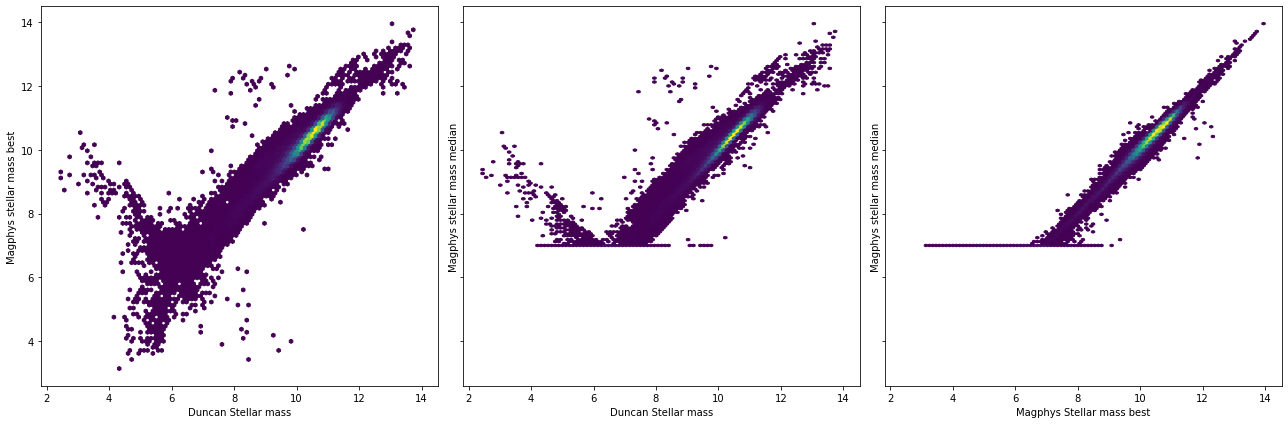

In [16]:
fig, ax = plt.subplots(1,3,figsize=(18,6),sharex='all',sharey='all')
# Plotting stellar mass histogram
ax[0].hexbin(table['Mass_median_2'],np.log10(table['Mstar_best']),mincnt=1)
ax[0].set_xlabel('Duncan Stellar mass')
ax[0].set_ylabel('Magphys stellar mass best')
# Plotting redshift histogram
ax[1].hexbin(table['Mass_median_2'],np.log10(table['Mstar_50']),mincnt=1)
ax[1].set_xlabel('Duncan Stellar mass')
ax[1].set_ylabel('Magphys stellar mass median')
# Plotting Stellar mass vs Redshift
ax[2].hexbin(np.log10(table['Mstar_best']),np.log10(table['Mstar_50']),mincnt=1)
ax[2].set_xlabel('Magphys Stellar mass best')
ax[2].set_ylabel('Magphys stellar mass median')
fig.tight_layout()
plt.show()

In [12]:
table = table[np.isfinite(table['SFR_50'])]
table = table[np.isfinite(table['ID_1'])]
len(table)

265891

In [13]:
table = table[table['Z_BEST_1']<1.5]
table = table[table['Z_BEST_1']>0.05]
len(table)

254724

In [14]:
table = table[table['chi2_99_flag']==0]
len(table)

229255

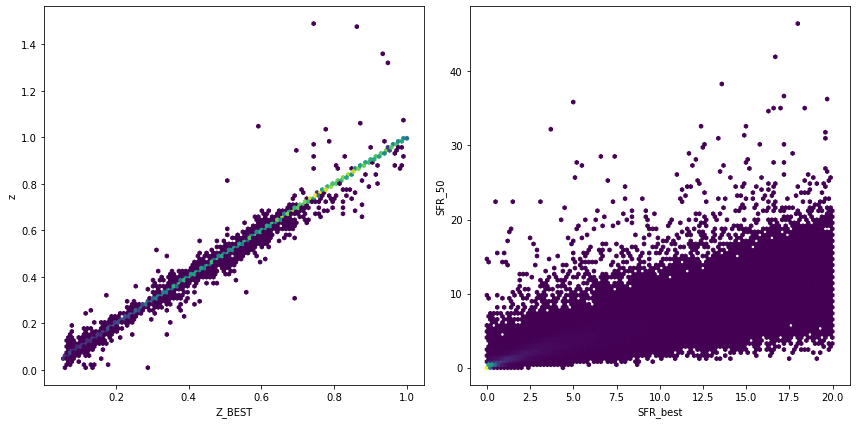

In [20]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
# Plotting stellar mass histogram
ax[0].hexbin(table['Z_BEST_1'],table['z'],mincnt=1)
ax[0].set_xlabel('Z_BEST')
ax[0].set_ylabel('z')
# Plotting redshift histogram
ax[1].hexbin(table.loc[table['SFR_best']<20,'SFR_best'],table.loc[table['SFR_best']<20,'SFR_50'],mincnt=1)
ax[1].set_xlabel('SFR_best')
ax[1].set_ylabel('SFR_50')
# Plotting Stellar mass vs Redshift
fig.tight_layout()
plt.show()

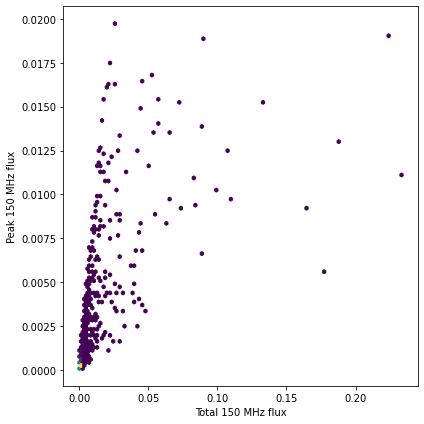

In [21]:
fig, ax = plt.subplots(figsize=(6,6))
# Plotting stellar mass histogram
ax.hexbin(table.loc[table['Peak_flux']<0.02,'Total_flux'],table.loc[table['Peak_flux']<0.02,'Peak_flux'],mincnt=1)
ax.set_xlabel('Total 150 MHz flux')
ax.set_ylabel('Peak 150 MHz flux')
fig.tight_layout()
plt.show()

In [15]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
import astropy.units as u

## Opening LOFAR map for selected field

In [16]:
### DON'T SKIP ###
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import wcs
#from astropy.wcs.utils import pixel_to_skycoord

In [17]:
# Opening LOFAR map
hdulist = fits.open(path+'Maps/'+map_lofar_file,memmap=True)
w_lofar = wcs.WCS(hdulist[0].header,naxis=2) # TAKE ONLY THE FIRST 2 DIMENSIONS (RA,DEC)

#hdulist[0].header

In [18]:
# Opening LOFAR map
hdulist1 = fits.open(path+'Maps/'+rms_lofar_file,memmap=True)
w_lofar1 = wcs.WCS(hdulist[0].header,naxis=2) # TAKE ONLY THE FIRST 2 DIMENSIONS (RA,DEC)

#hdulist1[0].header

In [19]:
print(w_lofar)
unit_lofar = hdulist[0].header['BUNIT'].replace(' ','')
print("Map unit : ",unit_lofar)
pixscale_lofar = hdulist[0].header['CDELT2']*3600 # PIXEL SCALE IN ARCSEC
print("Pixel scale : ",pixscale_lofar," arcseconds")
imdata_lofar = hdulist[0].data[0][0] # TAKING ONLY THE FIRST 2 DIMENSIONS (RA,DEC)
rmsdata_lofar = hdulist1[0].data[0][0] # TAKING ONLY THE FIRST 2 DIMENSIONS (RA,DEC)
hdulist.close()
hdulist1.close()

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 161.75  58.0833055556  
CRPIX : 9923.0  9923.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00041666666666667  0.00041666666666667  
NAXIS : 19845  19845  1  1
Map unit :  Jy/beam
Pixel scale :  1.500000000000012  arcseconds


In [27]:
imdata_lofar.shape

(19845, 19845)

In [28]:
fwhm_lofar = 6.0

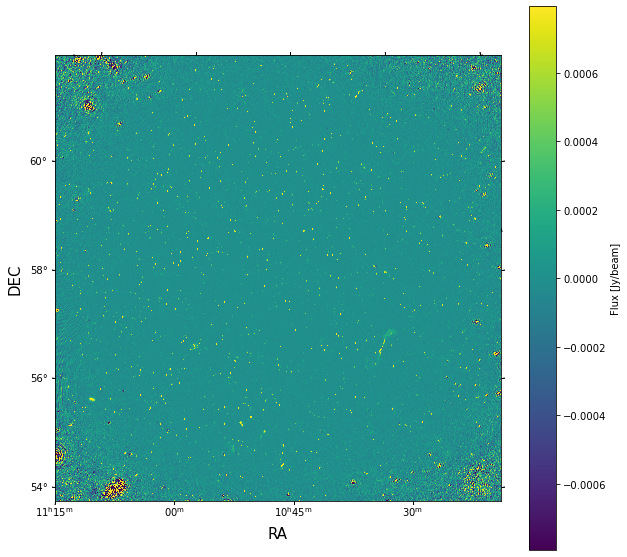

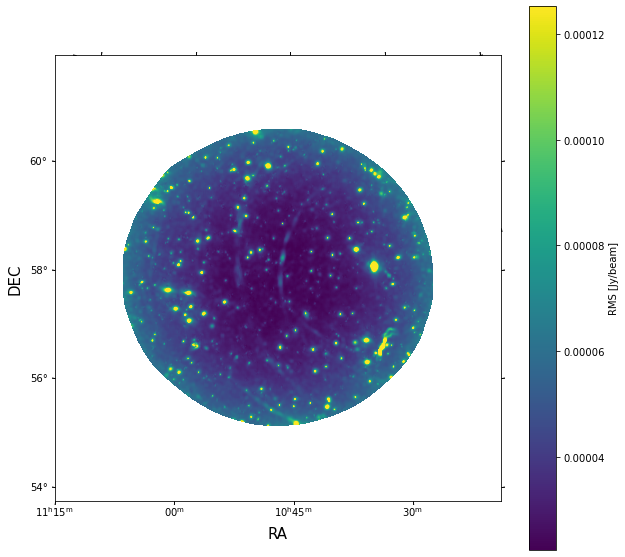

In [29]:
fig, ax = plt.subplots(figsize=(10,10),subplot_kw=dict(projection=w_lofar))
vis = ZScaleInterval(nsamples=1000, contrast=0.25, max_reject=0.5, min_npixels=5, krej=2.5, max_iterations=5)
vmin,vmax = vis.get_limits(imdata_lofar)
image = ax.imshow(imdata_lofar,vmin=vmin,vmax=vmax,origin='lower')
cb = fig.colorbar(image,ax=ax,label=f'Flux [{unit_lofar}]')
ax.set_xlabel('RA',size=15)
ax.set_ylabel('DEC',size=15)
plt.show()
fig, ax = plt.subplots(figsize=(10,10),subplot_kw=dict(projection=w_lofar))
vis = ZScaleInterval(nsamples=1000, contrast=0.25, max_reject=0.5, min_npixels=5, krej=2.5, max_iterations=5)
vmin,vmax = vis.get_limits(rmsdata_lofar)
image = ax.imshow(rmsdata_lofar,vmin=vmin,vmax=vmax,origin='lower')
cb = fig.colorbar(image,ax=ax,label=f'RMS [{unit_lofar}]')
ax.set_xlabel('RA',size=15)
ax.set_ylabel('DEC',size=15)
plt.show()

In [20]:
def get_pix_value(ra,dec,image,wcs):
        world_coords = [ra,dec]                                 # world coordinates
        pixel_coords = wcs.all_world2pix([world_coords], 0) # pixel coordinates
        position = (pixel_coords[0][0],pixel_coords[0][1])      # position to create cutout
        size = (1,1)                                            # cutout size in pixels
        #print(position)
        cutout = Cutout2D(image, position, size, mode='partial')
        
        return cutout.data[0][0]

In [21]:
table['pix_flux'] = [get_pix_value(ra,dec,imdata_lofar,w_lofar) for ra,dec in zip(table.loc[:,'RA_1'],table.loc[:,'DEC_1'])]

In [22]:
table['pix_rms'] = [get_pix_value(ra,dec,rmsdata_lofar,w_lofar1) for ra,dec in zip(table.loc[:,'RA_1'],table.loc[:,'DEC_1'])]

In [23]:
table['pix_StN'] = table['pix_flux']/table['pix_rms']

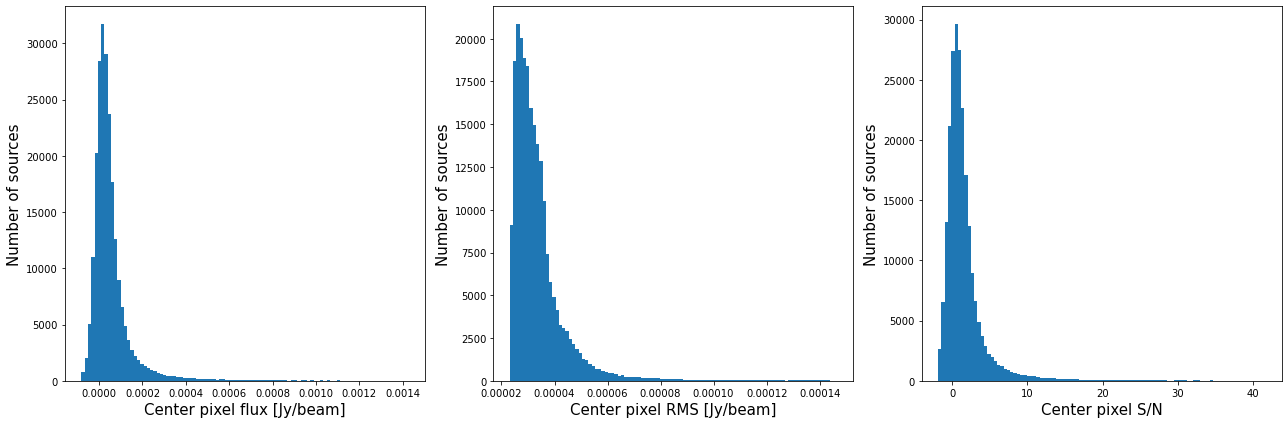

In [24]:
fig, ax = plt.subplots(1,3,figsize=(18,6))
ax[0].hist(table.loc[(table['pix_flux']>np.percentile(table['pix_flux'],0.5))&(table['pix_flux']<np.percentile(table['pix_flux'],99.5)),'pix_flux'],bins=100)
ax[0].set_xlabel('Center pixel flux [Jy/beam]',size=15)
ax[0].set_ylabel('Number of sources',size=15)
ax[1].hist(table.loc[(table['pix_rms']>np.percentile(table['pix_rms'],0.5))&(table['pix_rms']<np.percentile(table['pix_rms'],99.5)),'pix_rms'],bins=100)
ax[1].set_xlabel('Center pixel RMS [Jy/beam]',size=15)
ax[1].set_ylabel('Number of sources',size=15)
ax[2].hist(table.loc[(table['pix_StN']>np.percentile(table['pix_StN'],0.5))&(table['pix_StN']<np.percentile(table['pix_StN'],99.5)),'pix_StN'],bins=100)
ax[2].set_xlabel('Center pixel S/N',size=15)
ax[2].set_ylabel('Number of sources',size=15)
fig.tight_layout()
plt.show()

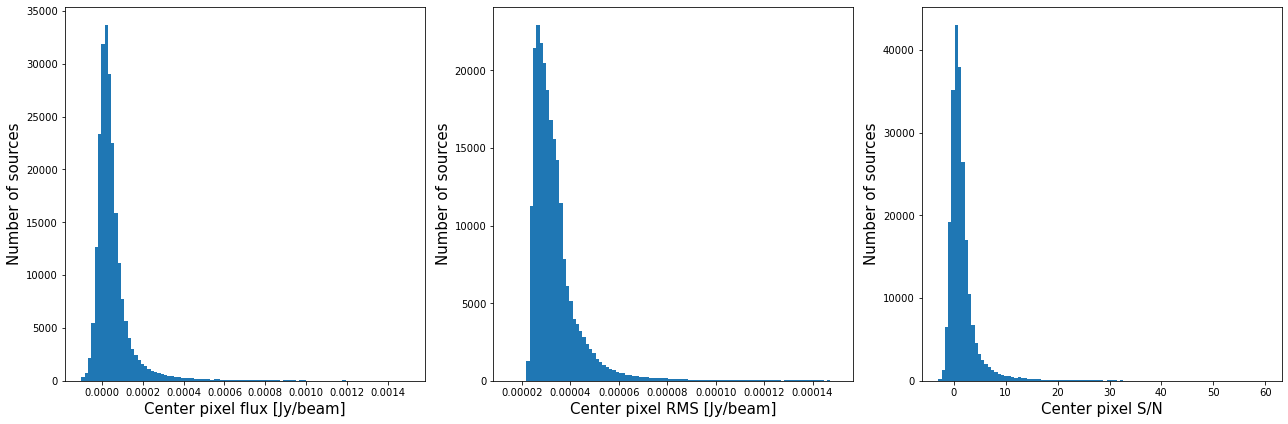

In [25]:
fig, ax = plt.subplots(1,3,figsize=(18,6))
ax[0].hist(table['pix_flux'],bins=np.linspace(-0.0001,0.0015,100))
ax[0].set_xlabel('Center pixel flux [Jy/beam]',size=15)
ax[0].set_ylabel('Number of sources',size=15)
ax[1].hist(table['pix_rms'],bins=np.linspace(0.000015,0.00015,100))
ax[1].set_xlabel('Center pixel RMS [Jy/beam]',size=15)
ax[1].set_ylabel('Number of sources',size=15)
ax[2].hist(table['pix_StN'],bins=np.linspace(-3,60,100))
ax[2].set_xlabel('Center pixel S/N',size=15)
ax[2].set_ylabel('Number of sources',size=15)
fig.tight_layout()
plt.show()

In [26]:
def Luminosity(flux,z):
    # From flux in mJy to luminosity in W/Hz
    L150 = (10**-29)*flux*4*np.pi*(cosmo.luminosity_distance(z).to(u.meter).value)**2
    #L150_unc = (10**-29)*flux_unc*4*np.pi*(cosmo.luminosity_distance(z).to(u.meter).value)**2
    
    return L150#, SFR, np.sqrt(SFR_unc2), SFR_M, np.sqrt(SFR_M_unc2)
Lum_v = np.vectorize(Luminosity)

In [27]:
table['L150_pix'] = Lum_v(table['pix_flux'],table['Z_BEST_1'])*10**3 # Flux is in Jy, not mJy

In [28]:
table['L150'] = table['L150_pix']
table.loc[np.isfinite(table['Total_flux']),'L150'] = Lum_v(table.loc[np.isfinite(table['Total_flux']),'Total_flux'],table.loc[np.isfinite(table['Total_flux']),'Z_BEST_1'])*10**3

C:\Users\bruno\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


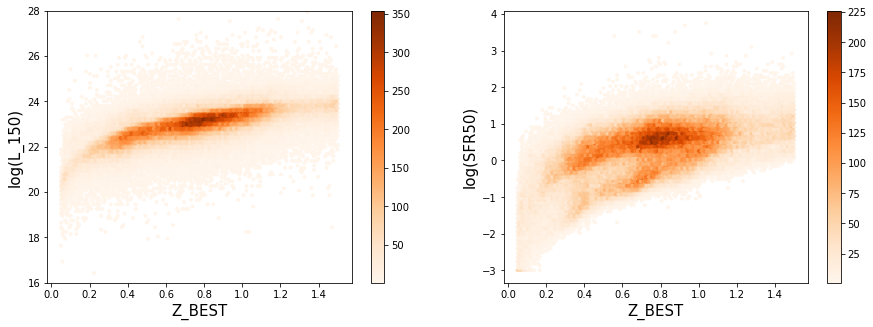

In [29]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
hb = ax[0].hexbin(table['Z_BEST_1'],np.log10(table['L150']),mincnt=1,cmap='Oranges')
cb = fig.colorbar(hb,ax=ax[0])
ax[0].set_xlabel('Z_BEST',size=15)
ax[0].set_ylabel('log(L_150)',size=15)
ax[0].set_ylim(16,28)
hb = ax[1].hexbin(table['Z_BEST_1'],np.log10(table['SFR_50']),mincnt=1,cmap='Oranges')
cb = fig.colorbar(hb,ax=ax[1])
ax[1].set_xlabel('Z_BEST',size=15)
ax[1].set_ylabel('log(SFR50)',size=15)
plt.show()

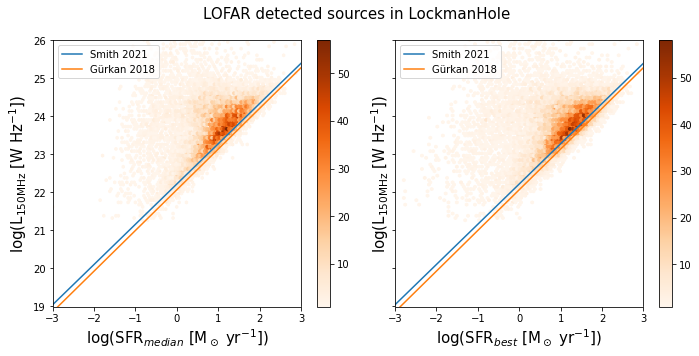

In [30]:
fig, ax = plt.subplots(1,2,figsize=(10,5),sharex='row',sharey='row')
hb = ax[0].hexbin(np.log10(table.loc[np.isfinite(table['Total_flux']),'SFR_50']),np.log10(table.loc[np.isfinite(table['Total_flux']),'L150']),mincnt=1,cmap='Oranges')
ax[0].set_xlabel('log(SFR$_{median}$ [M$_\odot$ yr$^{-1}$])',size=15)
ax[0].set_ylabel('log(L$_{150\mathrm{ MHz}}$ [W Hz$^{-1}$])',size=15)
ax[0].plot(np.arange(-3,4,1),1.058*np.arange(-3,4,1) + 22.221,label='Smith 2021')
ax[0].plot(np.arange(-3,4,1),1.07*np.arange(-3,4,1) + 22.07,label='Gürkan 2018')
cb = fig.colorbar(hb,ax=ax[0])
ax[0].set_xlim(-3,3)
ax[0].set_ylim(19,26)
ax[0].legend()
hb = ax[1].hexbin(np.log10(table.loc[np.isfinite(table['Total_flux']),'SFR_best']),np.log10(table.loc[np.isfinite(table['Total_flux']),'L150']),mincnt=1,cmap='Oranges')
ax[1].set_xlabel('log(SFR$_{best}$ [M$_\odot$ yr$^{-1}$])',size=15)
ax[1].set_ylabel('log(L$_{150\mathrm{ MHz}}$ [W Hz$^{-1}$])',size=15)
ax[1].plot(np.arange(-3,4,1),1.058*np.arange(-3,4,1) + 22.221,label='Smith 2021')
ax[1].plot(np.arange(-3,4,1),1.07*np.arange(-3,4,1) + 22.07,label='Gürkan 2018')
cb = fig.colorbar(hb,ax=ax[1])
ax[1].legend()
fig.suptitle('LOFAR detected sources in '+field, size=15)
fig.tight_layout()
plt.show()

C:\Users\bruno\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\bruno\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


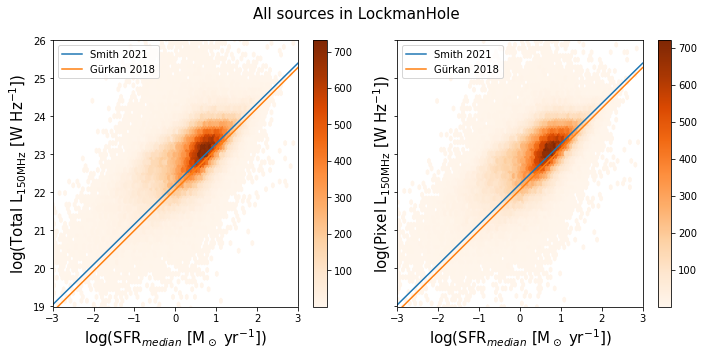

In [31]:
fig, ax = plt.subplots(1,2,figsize=(10,5),sharex='row',sharey='row')
hb = ax[0].hexbin(np.log10(table['SFR_50']),np.log10(table['L150']),mincnt=1,cmap='Oranges')
ax[0].set_xlabel('log(SFR$_{median}$ [M$_\odot$ yr$^{-1}$])',size=15)
ax[0].set_ylabel('log(Total L$_{150\mathrm{ MHz}}$ [W Hz$^{-1}$])',size=15)
ax[0].plot(np.arange(-3,4,1),1.058*np.arange(-3,4,1) + 22.221,label='Smith 2021')
ax[0].plot(np.arange(-3,4,1),1.07*np.arange(-3,4,1) + 22.07,label='Gürkan 2018')
cb = fig.colorbar(hb,ax=ax[0])
ax[0].set_xlim(-3,3)
ax[0].set_ylim(19,26)
ax[0].legend()
hb = ax[1].hexbin(np.log10(table['SFR_50']),np.log10(table['L150_pix']),mincnt=1,cmap='Oranges')
ax[1].set_xlabel('log(SFR$_{median}$ [M$_\odot$ yr$^{-1}$])',size=15)
ax[1].set_ylabel('log(Pixel L$_{150\mathrm{ MHz}}$ [W Hz$^{-1}$])',size=15)
ax[1].plot(np.arange(-3,4,1),1.058*np.arange(-3,4,1) + 22.221,label='Smith 2021')
ax[1].plot(np.arange(-3,4,1),1.07*np.arange(-3,4,1) + 22.07,label='Gürkan 2018')
cb = fig.colorbar(hb,ax=ax[1])
ax[1].legend()
fig.suptitle('All sources in '+field, size=15)
fig.tight_layout()
plt.show()

In [32]:
table['SFR_smith'] = np.power(10,(np.log10(table['L150']) - 22.221)/1.058)

C:\Users\bruno\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [33]:
m = np.arange(7,12.4,0.2)

def SchreiberMS(m1,z): ## For plotting Schreiber+15 main sequence
    return m1-9 - 0.5 + (1.5*np.log10(1+z)) - 0.3*(np.fmax(m1-9 - 0.36-2.5*np.log10(1+z),0.))**2

def SpeagleMS(m1,z): ## For plotting Speagle+14 main sequence:
    age = cosmo.age(z).value
    return (0.84-0.026*age)*m1-6.51+0.11*age

def CarnallQ(m1,z): ## For plotting Carnall+20 sSFR quiescent limit:
    age = cosmo.age(z).value
    return m1+np.log10(0.2/age)-9

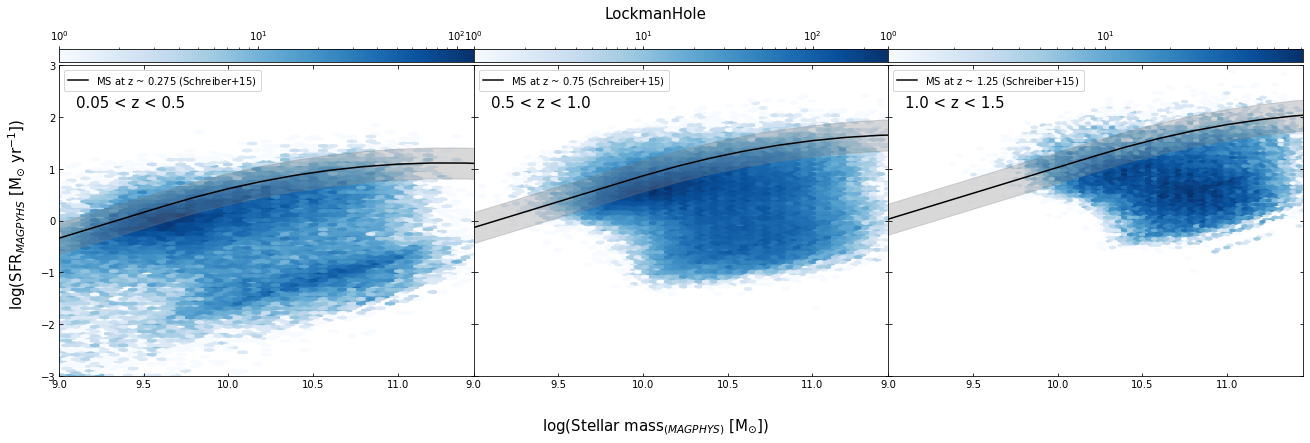

In [34]:
fig, ax = plt.subplots(1,3,figsize=(18,6),sharey='row')
for i, z1, z2 in zip([0,1,2],[0.05,0.5,1.],[0.5,1.,1.5]):
    z = (z1+z2)/2
    data = table[(table['Z_BEST_1']>z1)&(table['Z_BEST_1']<=z2)]
    hb = ax[i].hexbin(np.log10(data['Mstar_50']),
                      np.log10(data['SFR_50']),
                      cmap='Blues',mincnt=1,bins='log')
    ax[i].plot(m,SchreiberMS(m,z),ls='-', c='k', label=f'MS at z ~ ${z}$ (Schreiber+15)')
    ax[i].fill_between(m,SchreiberMS(m,z)-0.3,SchreiberMS(m,z)+0.3,alpha=0.3,color='grey')
    ax[i].text(9.1,2.2,f'{z1} < z < {z2}',size=15,color='k')
    ax[i].set_xlim(9,11.45)
    ax[i].set_ylim(-3,3)
    ax[i].tick_params(which='both',top=True,right=True,direction='in')
    ax[i].legend(loc='upper left')
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("top", size="4%", pad=0.05)
    cb = fig.colorbar(hb, cax=cax,orientation='horizontal')
    cax.tick_params(which='both',top=True,labeltop=True,bottom=False,labelbottom=False)
fig.text(0.5, 0.0,"log(Stellar mass$_{(MAGPHYS)}$ [M$_{\odot}$])", ha='center',fontsize=15)
fig.text(0.0, 0.5,"log(SFR$_{MAGPYHS}$ [M$_{\odot}$ yr$^{-1}$])", va='center',fontsize=15, rotation='vertical')
fig.subplots_adjust(left=0.04,right=1,wspace=0)
fig.suptitle(field, size=15)
plt.show()

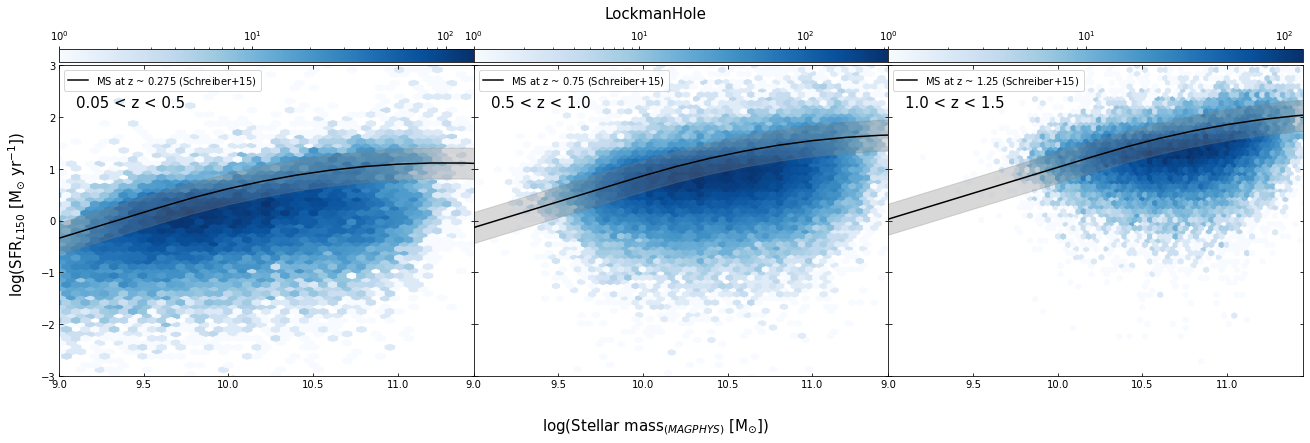

In [35]:
fig, ax = plt.subplots(1,3,figsize=(18,6),sharey='row')
for i, z1, z2 in zip([0,1,2],[0.05,0.5,1.],[0.5,1.,1.5]):
    z = (z1+z2)/2
    data = table[(table['Z_BEST_1']>z1)&(table['Z_BEST_1']<=z2)]
    hb = ax[i].hexbin(np.log10(data['Mstar_50']),
                      np.log10(data['SFR_smith']),
                      cmap='Blues',mincnt=1,bins='log')
    ax[i].plot(m,SchreiberMS(m,z),ls='-', c='k', label=f'MS at z ~ ${z}$ (Schreiber+15)')
    ax[i].fill_between(m,SchreiberMS(m,z)-0.3,SchreiberMS(m,z)+0.3,alpha=0.3,color='grey')
    ax[i].text(9.1,2.2,f'{z1} < z < {z2}',size=15,color='k')
    ax[i].set_xlim(9,11.45)
    ax[i].set_ylim(-3,3)
    ax[i].tick_params(which='both',top=True,right=True,direction='in')
    ax[i].legend(loc='upper left')
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("top", size="4%", pad=0.05)
    cb = fig.colorbar(hb, cax=cax,orientation='horizontal')
    cax.tick_params(which='both',top=True,labeltop=True,bottom=False,labelbottom=False)
fig.text(0.5, 0.0,"log(Stellar mass$_{(MAGPHYS)}$ [M$_{\odot}$])", ha='center',fontsize=15)
fig.text(0.0, 0.5,"log(SFR$_{L150}$ [M$_{\odot}$ yr$^{-1}$])", va='center',fontsize=15, rotation='vertical')
fig.subplots_adjust(left=0.04,right=1,wspace=0)
fig.suptitle(field, size=15)
plt.show()

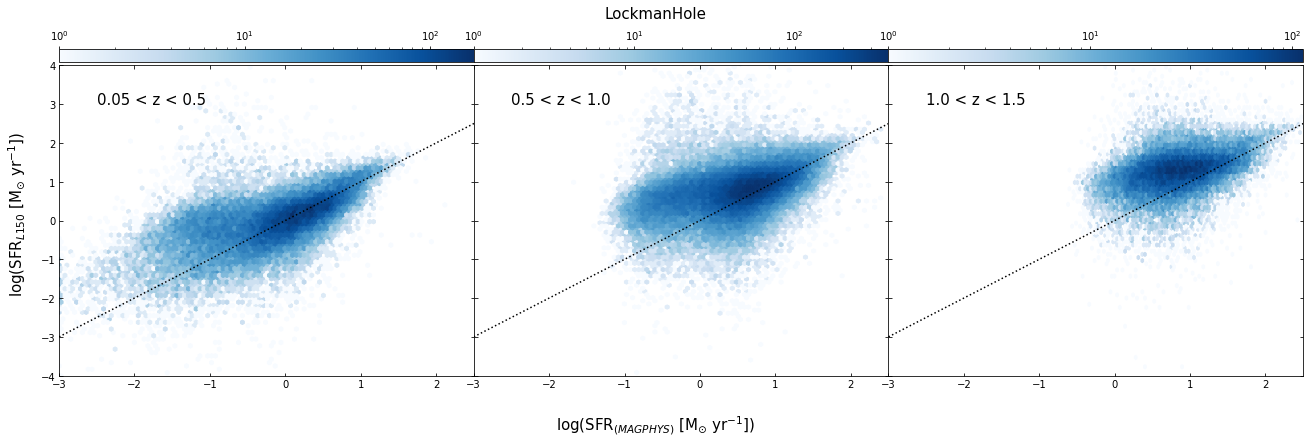

In [36]:
fig, ax = plt.subplots(1,3,figsize=(18,6),sharey='row')
for i, z1, z2 in zip([0,1,2],[0.05,0.5,1.],[0.5,1.,1.5]):
    z = (z1+z2)/2
    data = table[(table['Z_BEST_1']>z1)&(table['Z_BEST_1']<=z2)]
    hb = ax[i].hexbin(np.log10(data['SFR_50']),
                      np.log10(data['SFR_smith']),
                      cmap='Blues',mincnt=1,bins='log')
    ax[i].plot([-3,3],[-3,3],linestyle=':',c='k')
    ax[i].text(-2.5,3.,f'{z1} < z < {z2}',size=15,color='k')
    ax[i].set_xlim(-3,2.5)
    ax[i].set_ylim(-4,4)
    ax[i].tick_params(which='both',top=True,right=True,direction='in')
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("top", size="4%", pad=0.05)
    cb = fig.colorbar(hb, cax=cax,orientation='horizontal')
    cax.tick_params(which='both',top=True,labeltop=True,bottom=False,labelbottom=False)
fig.text(0.5, 0.0,"log(SFR$_{(MAGPHYS)}$ [M$_{\odot}$ yr$^{-1}$])", ha='center',fontsize=15)
fig.text(0.0, 0.5,"log(SFR$_{L150}$ [M$_{\odot}$ yr$^{-1}$])", va='center',fontsize=15, rotation='vertical')
fig.subplots_adjust(left=0.04,right=1,wspace=0)
fig.suptitle(field, size=15)
plt.show()

## Grouping galaxies by type, redshift and stellar mass

Here we can difine criteria to group by galaxy type (i.e. quiescent or star-forming) and in different redshift and stellar mass bins.

In [37]:
def create_bins(number,bin_width=1):
    q = np.floor(number/bin_width)
    return q*bin_width

In [38]:
mass_binwidth = 0.25
z_binwidth = 0.5

In [39]:
grouped_1 = table.groupby([create_bins(table.loc[:,'Z_BEST_1'],z_binwidth),create_bins(table.loc[:,'Mass_median_2'],mass_binwidth)])
stacked = grouped_1.median()[['Z_BEST_1','z','Mass_median_2','Mstar_50','SFR_50','pix_flux','L150','L150_pix','SFR_smith']]

In [40]:
stacked['SFR_std'] = grouped_1['SFR_50'].std()
stacked['SFR_16'] = grouped_1['SFR_50'].agg(lambda x: np.percentile(x,16))
stacked['SFR_84'] = grouped_1['SFR_50'].agg(lambda x: np.percentile(x,84))

In [41]:
stacked['L150_std'] = grouped_1['L150'].std()
stacked['L150_16'] = grouped_1['L150'].agg(lambda x: np.percentile(x,16))
stacked['L150_84'] = grouped_1['L150'].agg(lambda x: np.percentile(x,84))
stacked['pix_flux_16'] = grouped_1['pix_flux'].agg(lambda x: np.percentile(x,16))
stacked['pix_flux_84'] = grouped_1['pix_flux'].agg(lambda x: np.percentile(x,84))

C:\Users\bruno\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\bruno\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


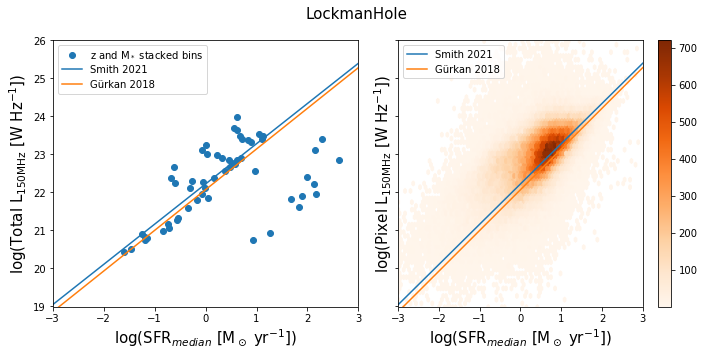

In [42]:
fig, ax = plt.subplots(1,2,figsize=(10,5),sharex='row',sharey='row')
ax[0].scatter(np.log10(stacked['SFR_50']),np.log10(stacked['L150']),label='z and M$_*$ stacked bins ')
ax[0].set_xlabel('log(SFR$_{median}$ [M$_\odot$ yr$^{-1}$])',size=15)
ax[0].set_ylabel('log(Total L$_{150\mathrm{ MHz}}$ [W Hz$^{-1}$])',size=15)
ax[0].plot(np.arange(-3,4,1),1.058*np.arange(-3,4,1) + 22.221,label='Smith 2021')
ax[0].plot(np.arange(-3,4,1),1.07*np.arange(-3,4,1) + 22.07,label='Gürkan 2018')
ax[0].set_xlim(-3,3)
ax[0].set_ylim(19,26)
ax[0].legend()
hb = ax[1].hexbin(np.log10(table['SFR_50']),np.log10(table['L150_pix']),mincnt=1,cmap='Oranges')
ax[1].set_xlabel('log(SFR$_{median}$ [M$_\odot$ yr$^{-1}$])',size=15)
ax[1].set_ylabel('log(Pixel L$_{150\mathrm{ MHz}}$ [W Hz$^{-1}$])',size=15)
ax[1].plot(np.arange(-3,4,1),1.058*np.arange(-3,4,1) + 22.221,label='Smith 2021')
ax[1].plot(np.arange(-3,4,1),1.07*np.arange(-3,4,1) + 22.07,label='Gürkan 2018')
cb = fig.colorbar(hb,ax=ax[1])
ax[1].legend()
fig.suptitle(field, size=15)
fig.tight_layout()
plt.show()

C:\Users\bruno\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\bruno\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\bruno\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
C:\Users\bruno\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


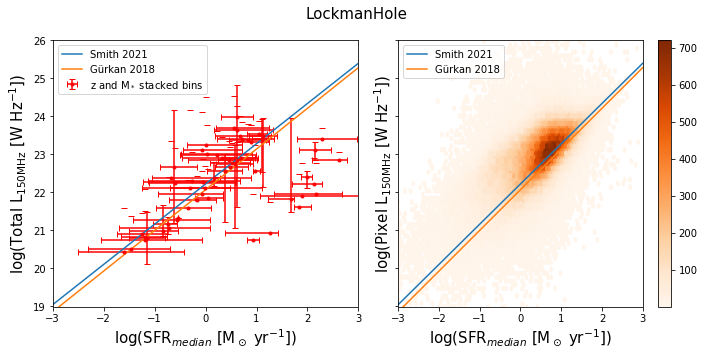

In [43]:
fig, ax = plt.subplots(1,2,figsize=(10,5),sharex='row',sharey='row')
ax[0].errorbar(np.log10(stacked['SFR_50']),np.log10(stacked['L150']),
               xerr=[np.log10(stacked['SFR_50'])-np.log10(stacked['SFR_16']),
                     np.log10(stacked['SFR_84'])-np.log10(stacked['SFR_50'])],
               yerr=[np.log10(stacked['L150'])-np.log10(stacked['L150_16']),
                     np.log10(stacked['L150_84'])-np.log10(stacked['L150'])],               
               label='z and M$_*$ stacked bins ',fmt='.r',capsize=3.)
ax[0].set_xlabel('log(SFR$_{median}$ [M$_\odot$ yr$^{-1}$])',size=15)
ax[0].set_ylabel('log(Total L$_{150\mathrm{ MHz}}$ [W Hz$^{-1}$])',size=15)
ax[0].plot(np.arange(-3,4,1),1.058*np.arange(-3,4,1) + 22.221,label='Smith 2021')
ax[0].plot(np.arange(-3,4,1),1.07*np.arange(-3,4,1) + 22.07,label='Gürkan 2018')
ax[0].set_xlim(-3,3)
ax[0].set_ylim(19,26)
ax[0].legend()
hb = ax[1].hexbin(np.log10(table['SFR_50']),np.log10(table['L150_pix']),mincnt=1,cmap='Oranges')
ax[1].set_xlabel('log(SFR$_{median}$ [M$_\odot$ yr$^{-1}$])',size=15)
ax[1].set_ylabel('log(Pixel L$_{150\mathrm{ MHz}}$ [W Hz$^{-1}$])',size=15)
ax[1].plot(np.arange(-3,4,1),1.058*np.arange(-3,4,1) + 22.221,label='Smith 2021')
ax[1].plot(np.arange(-3,4,1),1.07*np.arange(-3,4,1) + 22.07,label='Gürkan 2018')
cb = fig.colorbar(hb,ax=ax[1])
ax[1].legend()
fig.suptitle(field, size=15)
fig.tight_layout()
plt.show()

In [44]:
def SFR_smith(flux,mass,z):
    '''flux in Jy
    '''   
    #if flux <=0:
    #    new_flux = 2*10**-6 # noise limit???
    #else:
    #    new_flux = flux
    # Luminosity in W/Hz
    L150 = (10**-26)*flux*4*np.pi*(cosmo.luminosity_distance(z).to(u.meter).value)**2
    #L150_unc = (10**-29)*flux_unc*4*np.pi*(cosmo.luminosity_distance(z).to(u.meter).value)**2
    
    beta=1.058
    #beta_unc=0.007
    logL1=22.221
    #logL1_unc=0.008 
    #log10(L150) = 1.058*log10(SFR) + 22.221
    log10SFR = (np.log10(L150) - logL1)/beta
    SFR = 10**log10SFR
    #SFR_unc2 = ( (L150_unc/L150)**2 + (np.log(SFR)*beta_unc)**2 + (np.log(10)*logL1_unc)**2 )*((SFR/beta)**2)
    
    beta=0.903
    #beta_unc=0.012
    logLc=22.218
    #logLc_unc=0.016
    gamma=0.332
    #gamma_unc=0.037
    #log10(L150) = 0.9*log10(SFR) + 0.33*(M-10) + 22.22
    log10SFR = (np.log10(L150) - gamma*(mass-10) - logLc)/beta
    SFR_M = 10**log10SFR
    #SFR_M_unc2 = ( (L150_unc/L150)**2 + (np.log(SFR_M)*beta_unc)**2 + (np.log(10)*logLc_unc)**2 + (np.log(10)*(10-mass)*gamma_unc)**2 )*((SFR_M/beta)**2)

    return L150, SFR, SFR_M

SFR_smith_v = np.vectorize(SFR_smith)

In [45]:
stacked['L150_stack'], stacked['SFR_smith_stack'], stacked['SFR_smith_stack_M'] = SFR_smith_v(stacked['pix_flux'],stacked['Mass_median_2'],stacked['Z_BEST_1'])

x, stacked['SFR_smith_84'], stacked['SFR_smith_84_M'] = SFR_smith_v(stacked['pix_flux_84'],stacked['Mass_median_2'],stacked['Z_BEST_1'])
x, stacked['SFR_smith_16'], stacked['SFR_smith_16_M'] = SFR_smith_v(stacked['pix_flux_16'],stacked['Mass_median_2'],stacked['Z_BEST_1'])

C:\Users\bruno\AppData\Local\Temp\ipykernel_18320\2971261808.py:17: RuntimeWarning: invalid value encountered in log10
  log10SFR = (np.log10(L150) - logL1)/beta
C:\Users\bruno\AppData\Local\Temp\ipykernel_18320\2971261808.py:28: RuntimeWarning: invalid value encountered in log10
  log10SFR = (np.log10(L150) - gamma*(mass-10) - logLc)/beta
C:\Users\bruno\AppData\Local\Temp\ipykernel_18320\2971261808.py:17: RuntimeWarning: invalid value encountered in log10
  log10SFR = (np.log10(L150) - logL1)/beta
C:\Users\bruno\AppData\Local\Temp\ipykernel_18320\2971261808.py:28: RuntimeWarning: invalid value encountered in log10
  log10SFR = (np.log10(L150) - gamma*(mass-10) - logLc)/beta
C:\Users\bruno\AppData\Local\Temp\ipykernel_18320\2971261808.py:17: RuntimeWarning: invalid value encountered in log10
  log10SFR = (np.log10(L150) - logL1)/beta
C:\Users\bruno\AppData\Local\Temp\ipykernel_18320\2971261808.py:28: RuntimeWarning: invalid value encountered in log10
  log10SFR = (np.log10(L150) - gamm

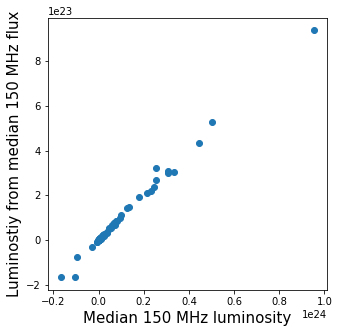

In [46]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(stacked['L150'],stacked['L150_stack'])
ax.set_xlabel('Median 150 MHz luminosity',size=15)
ax.set_ylabel('Luminostiy from median 150 MHz flux',size=15)
plt.show()

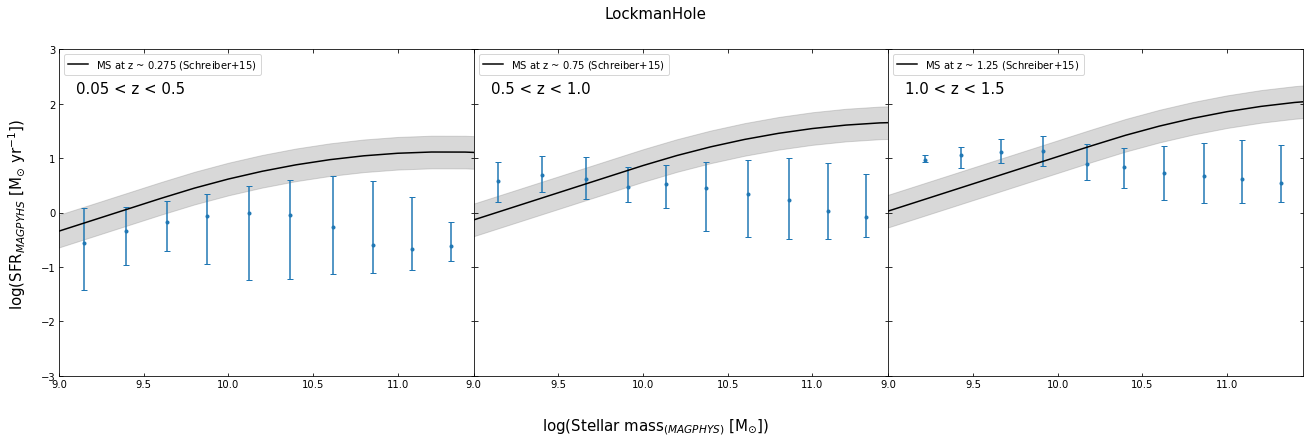

In [47]:
fig, ax = plt.subplots(1,3,figsize=(18,6),sharey='row')
for i, z1, z2 in zip([0,1,2],[0.05,0.5,1.],[0.5,1.,1.5]):
    z = (z1+z2)/2
    data = stacked[(stacked['Z_BEST_1']>z1)&(stacked['Z_BEST_1']<=z2)]
    ax[i].errorbar(data['Mass_median_2'],np.log10(data['SFR_50']),
                   yerr=[np.log10(data['SFR_50'])-np.log10(data['SFR_16']),
                         np.log10(data['SFR_84'])-np.log10(data['SFR_50'])],fmt='.',capsize=3.)
    ax[i].plot(m,SchreiberMS(m,z),ls='-', c='k', label=f'MS at z ~ ${z}$ (Schreiber+15)')
    ax[i].fill_between(m,SchreiberMS(m,z)-0.3,SchreiberMS(m,z)+0.3,alpha=0.3,color='grey')
    ax[i].text(9.1,2.2,f'{z1} < z < {z2}',size=15,color='k')
    ax[i].set_xlim(9,11.45)
    ax[i].set_ylim(-3,3)
    ax[i].tick_params(which='both',top=True,right=True,direction='in')
    ax[i].legend(loc='upper left')
fig.text(0.5, 0.0,"log(Stellar mass$_{(MAGPHYS)}$ [M$_{\odot}$])", ha='center',fontsize=15)
fig.text(0.0, 0.5,"log(SFR$_{MAGPYHS}$ [M$_{\odot}$ yr$^{-1}$])", va='center',fontsize=15, rotation='vertical')
fig.subplots_adjust(left=0.04,right=1,wspace=0)
fig.suptitle(field, size=15)
plt.show()

C:\Users\bruno\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\bruno\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
C:\Users\bruno\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\bruno\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
C:\Users\bruno\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\bruno\anaconda3\lib\site-packages\numpy\core\_

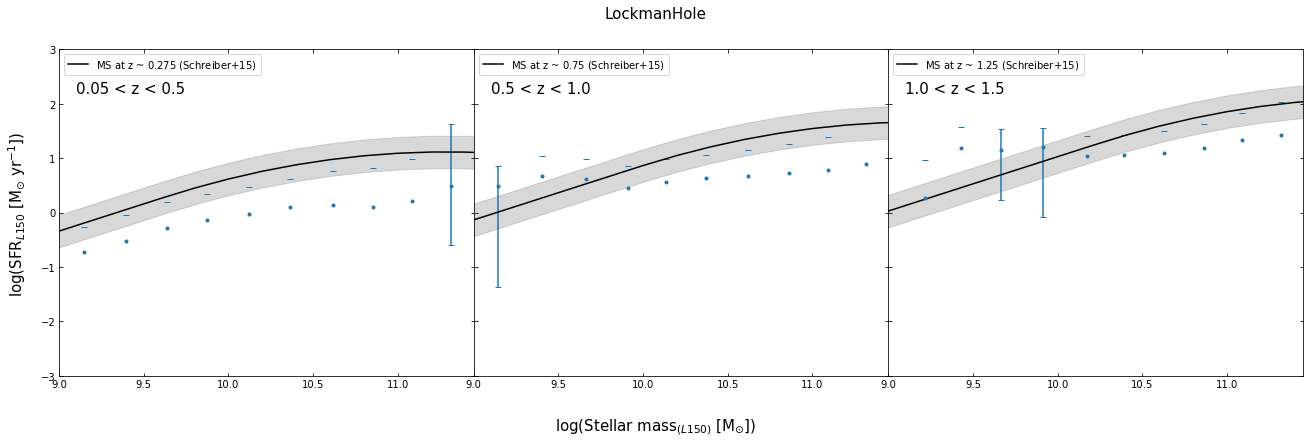

In [48]:
fig, ax = plt.subplots(1,3,figsize=(18,6),sharey='row')
for i, z1, z2 in zip([0,1,2],[0.05,0.5,1.],[0.5,1.,1.5]):
    z = (z1+z2)/2
    data = stacked[(stacked['Z_BEST_1']>z1)&(stacked['Z_BEST_1']<=z2)]
    ax[i].errorbar(data['Mass_median_2'],np.log10(data['SFR_smith_stack']),
                   yerr=[np.log10(data['SFR_smith_stack'])-np.log10(data['SFR_smith_16']),
                         np.log10(data['SFR_smith_84'])-np.log10(data['SFR_smith_stack'])],fmt='.',capsize=3.)
    ax[i].plot(m,SchreiberMS(m,z),ls='-', c='k', label=f'MS at z ~ ${z}$ (Schreiber+15)')
    ax[i].fill_between(m,SchreiberMS(m,z)-0.3,SchreiberMS(m,z)+0.3,alpha=0.3,color='grey')
    ax[i].text(9.1,2.2,f'{z1} < z < {z2}',size=15,color='k')
    ax[i].set_xlim(9,11.45)
    ax[i].set_ylim(-3,3)
    ax[i].tick_params(which='both',top=True,right=True,direction='in')
    ax[i].legend(loc='upper left')
fig.text(0.5, 0.0,"log(Stellar mass$_{(L150)}$ [M$_{\odot}$])", ha='center',fontsize=15)
fig.text(0.0, 0.5,"log(SFR$_{L150}$ [M$_{\odot}$ yr$^{-1}$])", va='center',fontsize=15, rotation='vertical')
fig.subplots_adjust(left=0.04,right=1,wspace=0)
fig.suptitle(field, size=15)
plt.show()

## Exploring color-color space

By choosing three rest-frame bands (in this case, NUV, R and J), we can define two colors which we will use to select galaxies as quiescent or star-forming. In order to have easy acces to these colors for later operations, we will add two new columns to the table based on the values of other columns.

In [49]:
### DON'T SKIP ###
table['NUVR'] = table['NUV_rest']-table['r_rest_2']
table['RJ'] = table['r_rest_2']-table['J_rest_2']

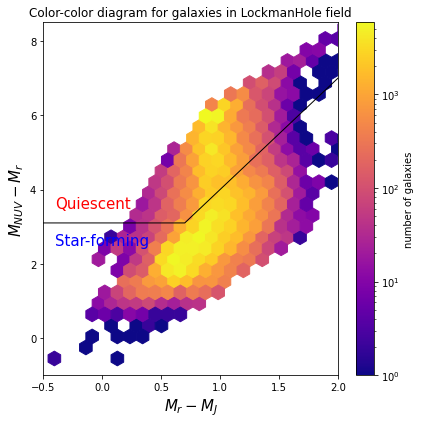

In [51]:
fig, axs = plt.subplots(figsize=(6,6))
axs.set_title('Color-color diagram for galaxies in '+field+' field')
axs.set_xlabel("$M_{r} - M_{J}$",fontsize=15)
axs.set_ylabel("$M_{NUV} - M_{r}$",fontsize=15)
hb = axs.hexbin(table['RJ'],table['NUVR'],bins='log',mincnt=1,cmap='plasma',gridsize=30)
cb = fig.colorbar(hb, ax=axs)
cb.set_label('number of galaxies')
axs.plot([-80,0.7,80],[3.1,3.1,241],color='k',linewidth=1,label='Color selection boundary')
axs.set_xlim(xmin=-0.5,xmax=2.)
axs.set_ylim(ymin=-1,ymax=8.5)
axs.text(-0.4,3.5,'Quiescent',size=15,color='r')
axs.text(-0.4,2.5,'Star-forming',size=15,color='b')
fig.tight_layout()
plt.show()

In [50]:
quiescent = '((NUVR>3.1)&(NUVR>3*RJ+1))'
SF = '((NUVR<=3.1)|(NUVR<=3*RJ+1))'

C:\Users\bruno\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\bruno\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


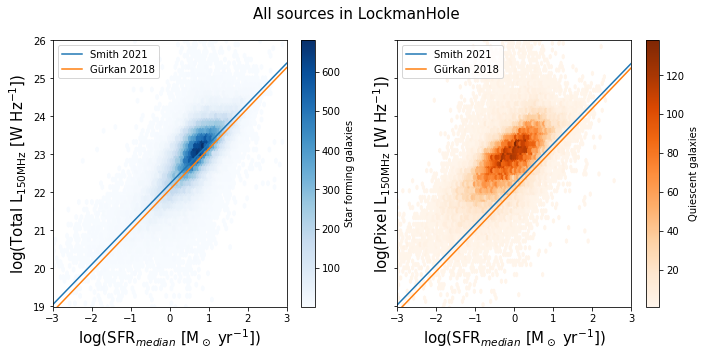

In [52]:
fig, ax = plt.subplots(1,2,figsize=(10,5),sharex='row',sharey='row')
hb = ax[0].hexbin(np.log10(table.query(SF)['SFR_50']),np.log10(table.query(SF)['L150']),mincnt=1,cmap='Blues')
ax[0].set_xlabel('log(SFR$_{median}$ [M$_\odot$ yr$^{-1}$])',size=15)
ax[0].set_ylabel('log(Total L$_{150\mathrm{ MHz}}$ [W Hz$^{-1}$])',size=15)
ax[0].plot(np.arange(-3,4,1),1.058*np.arange(-3,4,1) + 22.221,label='Smith 2021')
ax[0].plot(np.arange(-3,4,1),1.07*np.arange(-3,4,1) + 22.07,label='Gürkan 2018')
cb = fig.colorbar(hb,ax=ax[0],label='Star forming galaxies')
ax[0].set_xlim(-3,3)
ax[0].set_ylim(19,26)
ax[0].legend()
hb = ax[1].hexbin(np.log10(table.query(quiescent)['SFR_50']),np.log10(table.query(quiescent)['L150']),mincnt=1,cmap='Oranges')
ax[1].set_xlabel('log(SFR$_{median}$ [M$_\odot$ yr$^{-1}$])',size=15)
ax[1].set_ylabel('log(Pixel L$_{150\mathrm{ MHz}}$ [W Hz$^{-1}$])',size=15)
ax[1].plot(np.arange(-3,4,1),1.058*np.arange(-3,4,1) + 22.221,label='Smith 2021')
ax[1].plot(np.arange(-3,4,1),1.07*np.arange(-3,4,1) + 22.07,label='Gürkan 2018')
cb = fig.colorbar(hb,ax=ax[1],label='Quiescent galaxies')
ax[1].legend()
fig.suptitle('All sources in '+field, size=15)
fig.tight_layout()
plt.show()

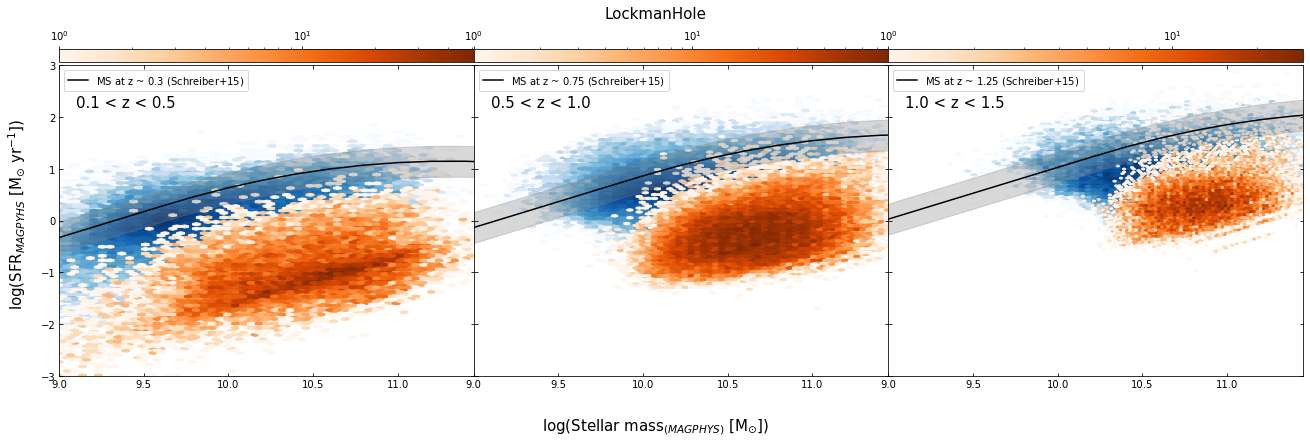

In [53]:
fig, ax = plt.subplots(1,3,figsize=(18,6),sharey='row')
for i, z1, z2 in zip([0,1,2],[0.1,0.5,1.],[0.5,1.,1.5]):
    z = (z1+z2)/2
    data = table[(table['Z_BEST_1']>z1)&(table['Z_BEST_1']<=z2)]
    hb = ax[i].hexbin(np.log10(data.query(SF)['Mstar_50']),
                      np.log10(data.query(SF)['SFR_50']),
                      cmap='Blues',mincnt=1,bins='log')
    hb = ax[i].hexbin(np.log10(data.query(quiescent)['Mstar_50']),
                      np.log10(data.query(quiescent)['SFR_50']),
                      cmap='Oranges',mincnt=1,bins='log')
    ax[i].plot(m,SchreiberMS(m,z),ls='-', c='k', label=f'MS at z ~ ${z}$ (Schreiber+15)')
    ax[i].fill_between(m,SchreiberMS(m,z)-0.3,SchreiberMS(m,z)+0.3,alpha=0.3,color='grey')
    ax[i].text(9.1,2.2,f'{z1} < z < {z2}',size=15,color='k')
    ax[i].set_xlim(9,11.45)
    ax[i].set_ylim(-3,3)
    ax[i].tick_params(which='both',top=True,right=True,direction='in')
    ax[i].legend(loc='upper left')
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("top", size="4%", pad=0.05)
    cb = fig.colorbar(hb, cax=cax,orientation='horizontal')
    cax.tick_params(which='both',top=True,labeltop=True,bottom=False,labelbottom=False)
fig.text(0.5, 0.0,"log(Stellar mass$_{(MAGPHYS)}$ [M$_{\odot}$])", ha='center',fontsize=15)
fig.text(0.0, 0.5,"log(SFR$_{MAGPYHS}$ [M$_{\odot}$ yr$^{-1}$])", va='center',fontsize=15, rotation='vertical')
fig.subplots_adjust(left=0.04,right=1,wspace=0)
fig.suptitle(field, size=15)
plt.show()

In [54]:
grouped_2 = table.query(SF).groupby([create_bins(table.loc[:,'Z_BEST_1'],z_binwidth),create_bins(table.loc[:,'Mass_median_2'],mass_binwidth)])
stacked_SFG = grouped_2.median()[['Z_BEST_1','z','Mass_median_2','Mstar_50','SFR_50','pix_flux','L150','L150_pix','SFR_smith']]

In [55]:
#stacked['SFR_std'] = grouped_1['SFR_50'].std()
stacked_SFG['SFR_16'] = grouped_2['SFR_50'].agg(lambda x: np.percentile(x,16))
stacked_SFG['SFR_84'] = grouped_2['SFR_50'].agg(lambda x: np.percentile(x,84))
stacked_SFG['L150_16'] = grouped_2['L150'].agg(lambda x: np.percentile(x,16))
stacked_SFG['L150_84'] = grouped_2['L150'].agg(lambda x: np.percentile(x,84))
stacked_SFG['pix_flux_16'] = grouped_2['pix_flux'].agg(lambda x: np.percentile(x,16))
stacked_SFG['pix_flux_84'] = grouped_2['pix_flux'].agg(lambda x: np.percentile(x,84))

In [56]:
grouped_3 = table.query(quiescent).groupby([create_bins(table.loc[:,'Z_BEST_1'],z_binwidth),create_bins(table.loc[:,'Mass_median_2'],mass_binwidth)])
stacked_QG = grouped_3.median()[['Z_BEST_1','z','Mass_median_2','Mstar_50','SFR_50','pix_flux','L150','L150_pix','SFR_smith']]

In [57]:
#stacked['SFR_std'] = grouped_1['SFR_50'].std()
stacked_QG['SFR_16'] = grouped_3['SFR_50'].agg(lambda x: np.percentile(x,16))
stacked_QG['SFR_84'] = grouped_3['SFR_50'].agg(lambda x: np.percentile(x,84))
stacked_QG['L150_16'] = grouped_3['L150'].agg(lambda x: np.percentile(x,16))
stacked_QG['L150_84'] = grouped_3['L150'].agg(lambda x: np.percentile(x,84))
stacked_QG['pix_flux_16'] = grouped_3['pix_flux'].agg(lambda x: np.percentile(x,16))
stacked_QG['pix_flux_84'] = grouped_3['pix_flux'].agg(lambda x: np.percentile(x,84))

C:\Users\bruno\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\bruno\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\bruno\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
C:\Users\bruno\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\bruno\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\bruno\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWa

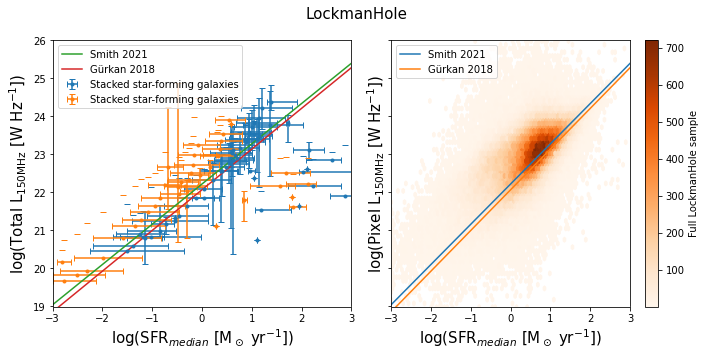

In [59]:
fig, ax = plt.subplots(1,2,figsize=(10,5),sharex='row',sharey='row')
#ax[0].scatter(np.log10(stacked_SFG['SFR_50']),np.log10(stacked_SFG['L150']),label='Stacked star-forming galaxies')
ax[0].errorbar(np.log10(stacked_SFG['SFR_50']),np.log10(stacked_SFG['L150']),
               xerr=[np.log10(stacked_SFG['SFR_50'])-np.log10(stacked_SFG['SFR_16']),
                     np.log10(stacked_SFG['SFR_84'])-np.log10(stacked_SFG['SFR_50'])],
               yerr=[np.log10(stacked_SFG['L150'])-np.log10(stacked_SFG['L150_16']),
                     np.log10(stacked_SFG['L150_84'])-np.log10(stacked_SFG['L150'])],
               label='Stacked star-forming galaxies',fmt='.',capsize=3.)
#ax[0].scatter(np.log10(stacked_QG['SFR_50']),np.log10(stacked_QG['L150']),label='Stacked quiescent galaxies')
ax[0].errorbar(np.log10(stacked_QG['SFR_50']),np.log10(stacked_QG['L150']),
               xerr=[np.log10(stacked_QG['SFR_50'])-np.log10(stacked_QG['SFR_16']),
                     np.log10(stacked_QG['SFR_84'])-np.log10(stacked_QG['SFR_50'])],
               yerr=[np.log10(stacked_QG['L150'])-np.log10(stacked_QG['L150_16']),
                     np.log10(stacked_QG['L150_84'])-np.log10(stacked_QG['L150'])],
               label='Stacked star-forming galaxies',fmt='.',capsize=3.)
ax[0].set_xlabel('log(SFR$_{median}$ [M$_\odot$ yr$^{-1}$])',size=15)
ax[0].set_ylabel('log(Total L$_{150\mathrm{ MHz}}$ [W Hz$^{-1}$])',size=15)
ax[0].plot(np.arange(-3,4,1),1.058*np.arange(-3,4,1) + 22.221,label='Smith 2021')
ax[0].plot(np.arange(-3,4,1),1.07*np.arange(-3,4,1) + 22.07,label='Gürkan 2018')
ax[0].set_xlim(-3,3)
ax[0].set_ylim(19,26)
ax[0].legend()
hb = ax[1].hexbin(np.log10(table['SFR_50']),np.log10(table['L150_pix']),mincnt=1,cmap='Oranges')
ax[1].set_xlabel('log(SFR$_{median}$ [M$_\odot$ yr$^{-1}$])',size=15)
ax[1].set_ylabel('log(Pixel L$_{150\mathrm{ MHz}}$ [W Hz$^{-1}$])',size=15)
ax[1].plot(np.arange(-3,4,1),1.058*np.arange(-3,4,1) + 22.221,label='Smith 2021')
ax[1].plot(np.arange(-3,4,1),1.07*np.arange(-3,4,1) + 22.07,label='Gürkan 2018')
cb = fig.colorbar(hb,ax=ax[1],label='Full '+field+' sample')
ax[1].legend()
fig.suptitle(field, size=15)
fig.tight_layout()
plt.show()

In [60]:
stacked_SFG['L150_stack'], stacked_SFG['SFR_smith_stack'], stacked_SFG['SFR_smith_stack_M'] = SFR_smith_v(stacked_SFG['pix_flux'],stacked_SFG['Mass_median_2'],stacked_SFG['Z_BEST_1'])
x, stacked_SFG['SFR_smith_84'], stacked_SFG['SFR_smith_84_M'] = SFR_smith_v(stacked_SFG['pix_flux_84'],stacked_SFG['Mass_median_2'],stacked_SFG['Z_BEST_1'])
x, stacked_SFG['SFR_smith_16'], stacked_SFG['SFR_smith_16_M'] = SFR_smith_v(stacked_SFG['pix_flux_16'],stacked_SFG['Mass_median_2'],stacked_SFG['Z_BEST_1'])

C:\Users\bruno\AppData\Local\Temp\ipykernel_18320\2971261808.py:17: RuntimeWarning: invalid value encountered in log10
  log10SFR = (np.log10(L150) - logL1)/beta
C:\Users\bruno\AppData\Local\Temp\ipykernel_18320\2971261808.py:28: RuntimeWarning: invalid value encountered in log10
  log10SFR = (np.log10(L150) - gamma*(mass-10) - logLc)/beta
C:\Users\bruno\AppData\Local\Temp\ipykernel_18320\2971261808.py:17: RuntimeWarning: invalid value encountered in log10
  log10SFR = (np.log10(L150) - logL1)/beta
C:\Users\bruno\AppData\Local\Temp\ipykernel_18320\2971261808.py:28: RuntimeWarning: invalid value encountered in log10
  log10SFR = (np.log10(L150) - gamma*(mass-10) - logLc)/beta
C:\Users\bruno\AppData\Local\Temp\ipykernel_18320\2971261808.py:17: RuntimeWarning: invalid value encountered in log10
  log10SFR = (np.log10(L150) - logL1)/beta
C:\Users\bruno\AppData\Local\Temp\ipykernel_18320\2971261808.py:28: RuntimeWarning: invalid value encountered in log10
  log10SFR = (np.log10(L150) - gamm

In [61]:
stacked_QG['L150_stack'], stacked_QG['SFR_smith_stack'], stacked_QG['SFR_smith_stack_M'] = SFR_smith_v(stacked_QG['pix_flux'],stacked_QG['Mass_median_2'],stacked_QG['Z_BEST_1'])
x, stacked_QG['SFR_smith_84'], stacked_QG['SFR_smith_84_M'] = SFR_smith_v(stacked_QG['pix_flux_84'],stacked_QG['Mass_median_2'],stacked_QG['Z_BEST_1'])
x, stacked_QG['SFR_smith_16'], stacked_QG['SFR_smith_16_M'] = SFR_smith_v(stacked_QG['pix_flux_16'],stacked_QG['Mass_median_2'],stacked_QG['Z_BEST_1'])

C:\Users\bruno\AppData\Local\Temp\ipykernel_18320\2971261808.py:17: RuntimeWarning: invalid value encountered in log10
  log10SFR = (np.log10(L150) - logL1)/beta
C:\Users\bruno\AppData\Local\Temp\ipykernel_18320\2971261808.py:28: RuntimeWarning: invalid value encountered in log10
  log10SFR = (np.log10(L150) - gamma*(mass-10) - logLc)/beta
C:\Users\bruno\AppData\Local\Temp\ipykernel_18320\2971261808.py:17: RuntimeWarning: invalid value encountered in log10
  log10SFR = (np.log10(L150) - logL1)/beta
C:\Users\bruno\AppData\Local\Temp\ipykernel_18320\2971261808.py:28: RuntimeWarning: invalid value encountered in log10
  log10SFR = (np.log10(L150) - gamma*(mass-10) - logLc)/beta
C:\Users\bruno\AppData\Local\Temp\ipykernel_18320\2971261808.py:17: RuntimeWarning: invalid value encountered in log10
  log10SFR = (np.log10(L150) - logL1)/beta
C:\Users\bruno\AppData\Local\Temp\ipykernel_18320\2971261808.py:28: RuntimeWarning: invalid value encountered in log10
  log10SFR = (np.log10(L150) - gamm

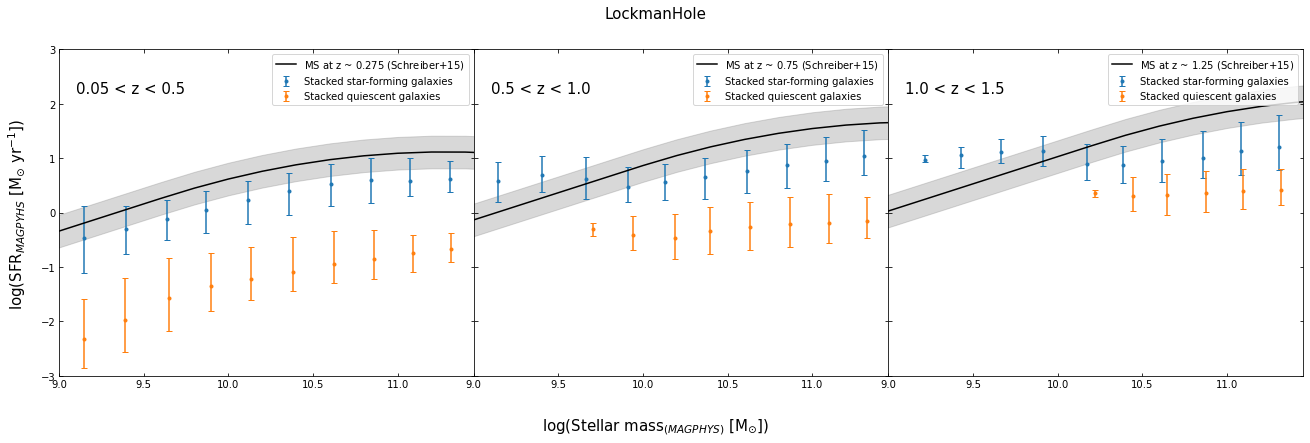

In [62]:
fig, ax = plt.subplots(1,3,figsize=(18,6),sharey='row')
for i, z1, z2 in zip([0,1,2],[0.05,0.5,1.],[0.5,1.,1.5]):
    z = (z1+z2)/2
    data = stacked_SFG[(stacked_SFG['Z_BEST_1']>z1)&(stacked_SFG['Z_BEST_1']<=z2)]
    #ax[i].scatter(data['Mass_median_2'],np.log10(data['SFR_50']),label='Stacked star-forming galaxies')
    ax[i].errorbar(data['Mass_median_2'],np.log10(data['SFR_50']),
                   yerr=[np.log10(data['SFR_50'])-np.log10(data['SFR_16']),
                         np.log10(data['SFR_84'])-np.log10(data['SFR_50'])],label='Stacked star-forming galaxies',fmt='.',capsize=3.)
    
    data = stacked_QG[(stacked_QG['Z_BEST_1']>z1)&(stacked_QG['Z_BEST_1']<=z2)]
    #ax[i].scatter(data['Mass_median_2'],np.log10(data['SFR_50']),label='Stacked quiescent galaxies')
    ax[i].errorbar(data['Mass_median_2'],np.log10(data['SFR_50']),
                   yerr=[np.log10(data['SFR_50'])-np.log10(data['SFR_16']),
                         np.log10(data['SFR_84'])-np.log10(data['SFR_50'])],label='Stacked quiescent galaxies',fmt='.',capsize=3.)
    ax[i].plot(m,SchreiberMS(m,z),ls='-', c='k', label=f'MS at z ~ ${z}$ (Schreiber+15)')
    ax[i].fill_between(m,SchreiberMS(m,z)-0.3,SchreiberMS(m,z)+0.3,alpha=0.3,color='grey')
    ax[i].text(9.1,2.2,f'{z1} < z < {z2}',size=15,color='k')
    ax[i].set_xlim(9,11.45)
    ax[i].set_ylim(-3,3)
    ax[i].tick_params(which='both',top=True,right=True,direction='in')
    ax[i].legend(loc='upper right')
fig.text(0.5, 0.0,"log(Stellar mass$_{(MAGPHYS)}$ [M$_{\odot}$])", ha='center',fontsize=15)
fig.text(0.0, 0.5,"log(SFR$_{MAGPYHS}$ [M$_{\odot}$ yr$^{-1}$])", va='center',fontsize=15, rotation='vertical')
fig.subplots_adjust(left=0.04,right=1,wspace=0)
fig.suptitle(field, size=15)
plt.show()

C:\Users\bruno\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\bruno\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
C:\Users\bruno\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\bruno\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
C:\Users\bruno\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\bruno\anaconda3\lib\site-packages\numpy\core\_

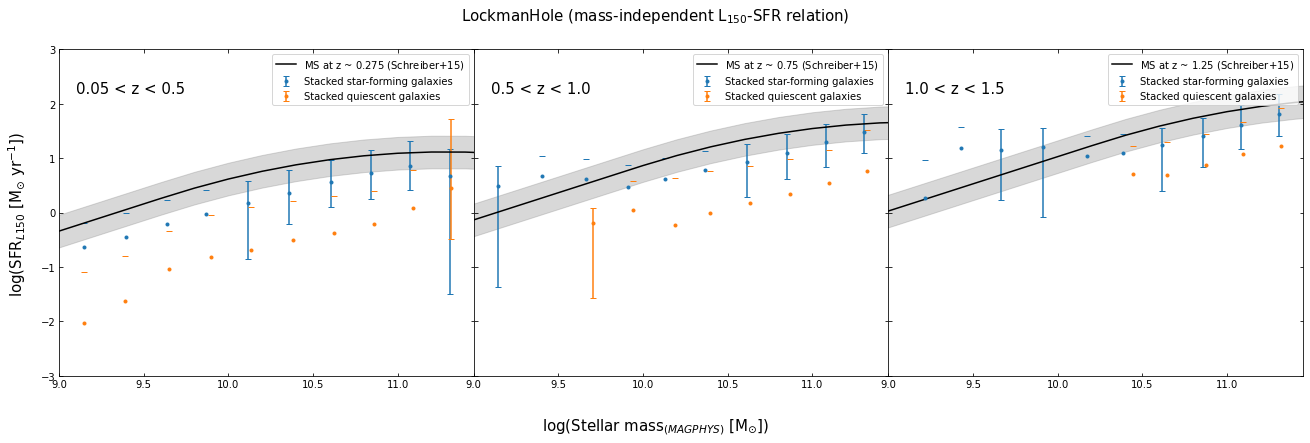

In [63]:
fig, ax = plt.subplots(1,3,figsize=(18,6),sharey='row')
for i, z1, z2 in zip([0,1,2],[0.05,0.5,1.],[0.5,1.,1.5]):
    z = (z1+z2)/2
    data = stacked_SFG[(stacked_SFG['Z_BEST_1']>z1)&(stacked_SFG['Z_BEST_1']<=z2)]
    #ax[i].scatter(data['Mass_median_2'],np.log10(data['SFR_smith_stack']),label='Stacked star-forming galaxies')
    ax[i].errorbar(data['Mass_median_2'],np.log10(data['SFR_smith_stack']),
                   yerr=[np.log10(data['SFR_smith_stack'])-np.log10(data['SFR_smith_16']),
                         np.log10(data['SFR_smith_84'])-np.log10(data['SFR_smith_stack'])],label='Stacked star-forming galaxies',fmt='.',capsize=3.)
    
    data = stacked_QG[(stacked_QG['Z_BEST_1']>z1)&(stacked_QG['Z_BEST_1']<=z2)]
    #ax[i].scatter(data['Mass_median_2'],np.log10(data['SFR_smith_stack']),label='Stacked quiescent galaxies')
    ax[i].errorbar(data['Mass_median_2'],np.log10(data['SFR_smith_stack']),
                   yerr=[np.log10(data['SFR_smith_stack'])-np.log10(data['SFR_smith_16']),
                         np.log10(data['SFR_smith_84'])-np.log10(data['SFR_smith_stack'])],label='Stacked quiescent galaxies',fmt='.',capsize=3.)
    ax[i].plot(m,SchreiberMS(m,z),ls='-', c='k', label=f'MS at z ~ ${z}$ (Schreiber+15)')
    ax[i].fill_between(m,SchreiberMS(m,z)-0.3,SchreiberMS(m,z)+0.3,alpha=0.3,color='grey')
    ax[i].text(9.1,2.2,f'{z1} < z < {z2}',size=15,color='k')
    ax[i].set_xlim(9,11.45)
    ax[i].set_ylim(-3,3)
    ax[i].tick_params(which='both',top=True,right=True,direction='in')
    ax[i].legend(loc='upper right')
fig.text(0.5, 0.0,"log(Stellar mass$_{(MAGPHYS)}$ [M$_{\odot}$])", ha='center',fontsize=15)
fig.text(0.0, 0.5,"log(SFR$_{L150}$ [M$_{\odot}$ yr$^{-1}$])", va='center',fontsize=15, rotation='vertical')
fig.subplots_adjust(left=0.04,right=1,wspace=0)
fig.suptitle(field+' (mass-independent L$_{150}$-SFR relation)', size=15)
plt.show()

C:\Users\bruno\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\bruno\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
C:\Users\bruno\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\bruno\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
C:\Users\bruno\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\bruno\anaconda3\lib\site-packages\numpy\core\_

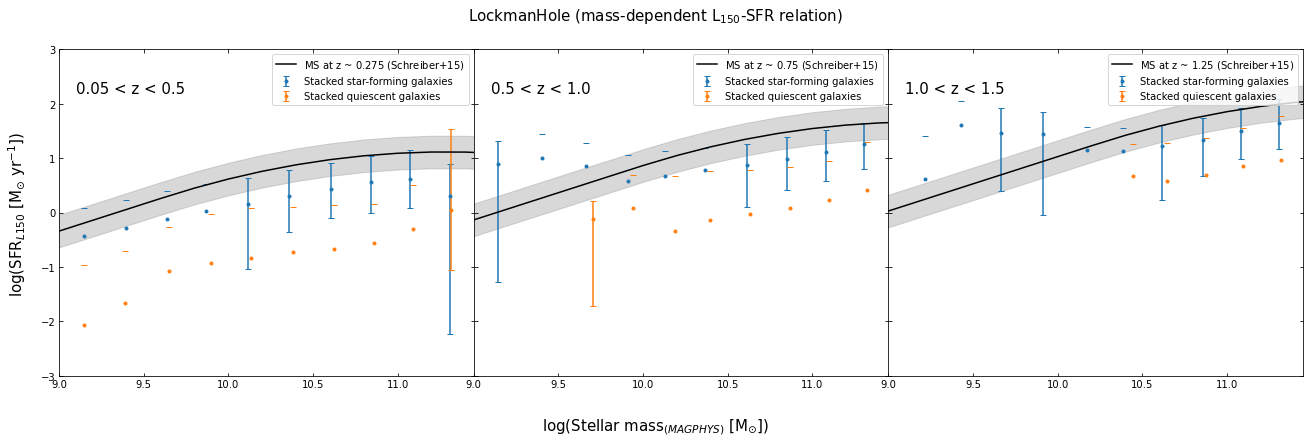

In [64]:
fig, ax = plt.subplots(1,3,figsize=(18,6),sharey='row')
for i, z1, z2 in zip([0,1,2],[0.05,0.5,1.],[0.5,1.,1.5]):
    z = (z1+z2)/2
    data = stacked_SFG[(stacked_SFG['Z_BEST_1']>z1)&(stacked_SFG['Z_BEST_1']<=z2)]
    #ax[i].scatter(data['Mass_median_2'],np.log10(data['SFR_smith_stack_M']),label='Stacked star-forming galaxies')
    ax[i].errorbar(data['Mass_median_2'],np.log10(data['SFR_smith_stack_M']),
                   yerr=[np.log10(data['SFR_smith_stack_M'])-np.log10(data['SFR_smith_16_M']),
                         np.log10(data['SFR_smith_84_M'])-np.log10(data['SFR_smith_stack_M'])],label='Stacked star-forming galaxies',fmt='.',capsize=3.)
    
    data = stacked_QG[(stacked_QG['Z_BEST_1']>z1)&(stacked_QG['Z_BEST_1']<=z2)]
    #ax[i].scatter(data['Mass_median_2'],np.log10(data['SFR_smith_stack_M']),label='Stacked quiescent galaxies')
    ax[i].errorbar(data['Mass_median_2'],np.log10(data['SFR_smith_stack_M']),
                   yerr=[np.log10(data['SFR_smith_stack_M'])-np.log10(data['SFR_smith_16_M']),
                         np.log10(data['SFR_smith_84_M'])-np.log10(data['SFR_smith_stack_M'])],label='Stacked quiescent galaxies',fmt='.',capsize=3.)
    ax[i].plot(m,SchreiberMS(m,z),ls='-', c='k', label=f'MS at z ~ ${z}$ (Schreiber+15)')
    ax[i].fill_between(m,SchreiberMS(m,z)-0.3,SchreiberMS(m,z)+0.3,alpha=0.3,color='grey')
    ax[i].text(9.1,2.2,f'{z1} < z < {z2}',size=15,color='k')
    ax[i].set_xlim(9,11.45)
    ax[i].set_ylim(-3,3)
    ax[i].tick_params(which='both',top=True,right=True,direction='in')
    ax[i].legend(loc='upper right')
fig.text(0.5, 0.0,"log(Stellar mass$_{(MAGPHYS)}$ [M$_{\odot}$])", ha='center',fontsize=15)
fig.text(0.0, 0.5,"log(SFR$_{L150}$ [M$_{\odot}$ yr$^{-1}$])", va='center',fontsize=15, rotation='vertical')
fig.subplots_adjust(left=0.04,right=1,wspace=0)
fig.suptitle(field+' (mass-dependent L$_{150}$-SFR relation)', size=15)
plt.show()

# NOTEBOOK ENDS HERE